In [4]:
import time
import sys
from datetime import datetime
from pathlib import Path
from os import listdir
from os.path import isfile, join

import numpy as np
import cv2
from PIL import Image

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from ahds import AmiraFile

In [5]:
def read_amira_volume(amira_file_name):
    
    af = AmiraFile(amira_file_name, load_streams=False)
    header_length = af.meta.header_length

    #print(af)
    #print('Header length', header_length)

    w = af.header.Lattice.length[0]
    h = af.header.Lattice.length[1]
    d = af.header.Lattice.length[2]
    
    start = time.time()

    data = np.fromfile(amira_file_name, dtype=np.uint8, count=-1, offset=header_length+5)

    #print(w*h*d)
    #print(len(data))
    data = data.reshape((d, h, w))

    end = time.time()
    print(f'Read time:{end-start}')
    
    return data


def read_amira_labels(amira_file_name):
    start = time.time()
    af = AmiraFile(amira_file_name, load_streams=True)
    header_length = af.meta.header_length
    labels = af.data_streams.Labels.data
    
    end = time.time()
    print(f'Read time:{end-start}')
    
    return labels

def get_extents(volume):
    z,y,x = np.where(volume != 0)
    
    return (np.min(z), np.max(z)), (np.min(y), np.max(y)), (np.min(x), np.max(x))


def save_np_sequence_as_multitiff_stack(images, file_name):
    
    imlist = []
    for i in range(len(images)):
        imlist.append(Image.fromarray(images[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist    
    
def save_np_as_multitiff_stack(volume, file_name):
    
    imlist = []
    for i in range(volume.shape[0]):
        imlist.append(Image.fromarray(volume[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist 

In [39]:
#data_path = Path('../unet-pytorch/data')

d = '751'

data_path = Path(f'/mnt/LSDF/projects/code-vita/Medaka/2018_11_Segmented/Segmentation of heart/{d}/')

In [40]:
vol = read_amira_volume(data_path / f'{d}_8bit-10000.tif.am')

Using pattern: b'(?:^|\n)@(?P<stream>\\d+)\n'


Read time:14.665725231170654


In [44]:
label = read_amira_labels(data_path / f'{d}-files' / f'{d}_8bit-10000.tif-labels.am')

Using pattern: b'(?:^|\n)@(?P<stream>\\d+)\n'


Read time:4.056216239929199


In [45]:
ext = get_extents(label)
ext

((2626, 2906), (863, 1048), (578, 721))

In [47]:
#z = ext[0][1]

z = 4500

im = vol[z,:,:]
plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()

im = label[z,:,:]
plt.imshow(im)
plt.colorbar()
plt.show()

IndexError: index 4500 is out of bounds for axis 0 with size 3500

In [27]:
z0 = ext[0][0]
z1 = ext[0][1]
y0 = ext[1][0]
y1 = ext[1][1]
x0 = ext[2][0]
x1 = ext[2][1]

crop = vol[z0:z1, y0:y1, x0:x1]
save_np_as_multitiff_stack(crop, 'data/crop.tif')

crop = label[z0:z1, y0:y1, x0:x1]
save_np_as_multitiff_stack(crop, 'data/crop_labels.tif')

In [25]:
def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
 
    img = Image.open(path)
    #images = np.array()
    images = []
    for i in range(n_images):
        try:
            img.seek(i)

            #np.stack(images, np.array(img))
            images.append(np.array(img))

        except EOFError:
            # Not enough frames in img
            break
            
    return np.array(images)


d = '509_33-1'

    
#data_path = Path(f'/mnt/LSDF/projects/code-vita/Medaka/2018_11/Medaka_{d}/slices/')

start = time.time()
v1 = read_tiff(str(data_path / 'slice-2-0003.tif'), 264)   
v2 = read_tiff(str(data_path / 'slice-2-0002.tif'), 264)
v3 = read_tiff(str(data_path / 'slice-2-0001.tif'), 264)

end = time.time()
print(f'Read time:{end-start}')

Read time:53.41691565513611


In [29]:
vol = np.concatenate((v3, v2, v1), axis=0)
vol.shape

(792, 2016, 2016)

In [36]:
data_path = Path(f'/mnt/HD-LSDF/sd18a004/Medaka_2019_12/Medaka_1417_140-3/')
vol = read_tiff(str(data_path / 'slices.tif'), 264) 

OSError: cannot identify image file '/mnt/HD-LSDF/sd18a004/Medaka_2019_12/Medaka_1417_140-3/slices.tif'

In [30]:
def plot_slice_intensities(vol):

    avg = np.mean(vol, axis=(1,2))
    std = np.std(vol, axis=(1,2))
    m = np.max(vol, axis=(1,2))

    #m.shape
    plt.plot(avg)
    plt.plot(std)
    plt.plot(m)

    plt.show()
    

#plot_slice_intensities(vol)


avg_0 = np.mean(vol, axis=(0))
avg_1 = np.mean(vol, axis=(1))
avg_2 = np.mean(vol, axis=(2))


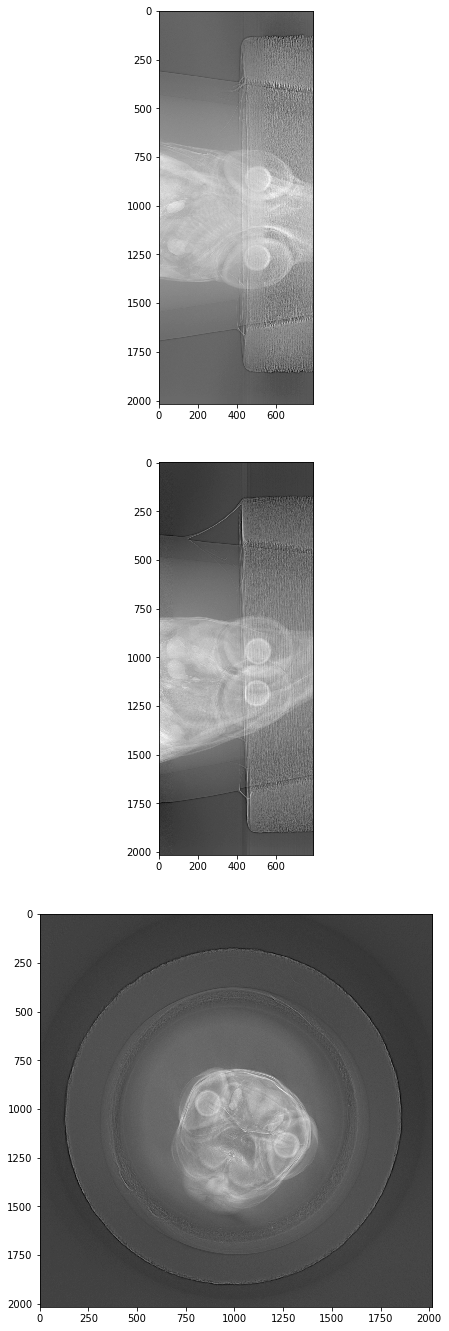

In [31]:
fig = plt.figure()
fig.set_size_inches(18, 18, forward=True)
plt.subplots_adjust(top=1.0, bottom=0.0, left=0.0, right=1.0, wspace=0.15, hspace=0.15 )

gs = gridspec.GridSpec(3,1)

ax0 = plt.subplot(gs[0, 0])   
ax0.imshow(avg_1.T, cmap='gray')

ax1 = plt.subplot(gs[1, 0]) 
ax1.imshow(avg_2.T, cmap='gray')

ax2 = plt.subplot(gs[2, 0]) 
ax2.imshow(avg_0, cmap='gray')

plt.show()

In [33]:
crop = vol[:, 750:1600, 600:1500]
save_np_as_multitiff_stack(crop, f'data/{d}_crop.tif')

In [34]:
crop.shape

(792, 850, 900)

## Read series of tif-stacks

Read time:9.821028232574463
